**Name:** Disaster Tweet Classifier

**Author:** Sharome Burton

**Date:** 07/19/2021

**Description:** Machine learning model used to predict whether a tweet is about a real disaster or not.

## 1. Problem definition
> How well can we predict whether a tweet is about a disaster or not?

## 2. Data
   * `train.csv` - the training set
   * `test.csv` - the test set
    
 source: https://www.kaggle.com/c/nlp-getting-started/data

   
## 3. Evaluation 

> **Goal:** Predict the whether a tweet is about a disaster or not with >80% accuracy.

## 4. Features

   * id - a unique identifier for each tweet
   * text - the text of the tweet
   * location - the location the tweet was sent from (may be blank)
   * keyword - a particular keyword from the tweet (may be blank)
   * target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


In [296]:
### Import libraries

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Packages for basic text processing
import re
import string 

## Visualization tools
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

## Import Logistic Regression function for model training from linear model module of sklearn package
from sklearn.linear_model import LogisticRegression

## Import functions for evaluation from  model selection module of sklearn package
from sklearn.metrics import confusion_matrix, accuracy_score

## Import functions for model selection from model selection module of sklearn package
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## Import functions for text vectorization from feature extraction module of sklearn package
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Import function from NLTK package for Text tokenization and Normalization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

## Ignore warnings
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Loading data

In [297]:
tweets_raw = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
tweets_raw_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## Exploratory Data Analysis (EDA)



In [298]:
tweets_raw

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [299]:
# Tweets about real disaster
tweets_raw[tweets_raw["target"] == 1]["text"].values[:5]


array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

In [300]:
# Tweets not about real disaster
tweets_raw[tweets_raw["target"] == 0]["text"].values[:5]


array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!'], dtype=object)

In [301]:
# Check for missing data
tweets_raw.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [302]:
# Discarding columns except text and target
tweets=tweets_raw[['text','target']]

<AxesSubplot:xlabel='target', ylabel='count'>

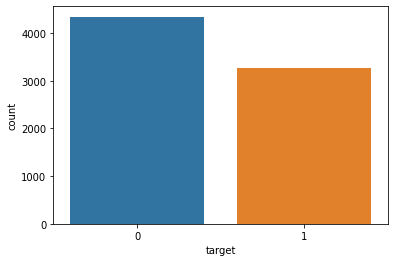

In [303]:
# Number of occurences of real disasters
sns.countplot(x=tweets["target"])

In [304]:
print(f'{tweets.target[tweets.target==1].count()/tweets.target.count()*100:.2f} % of tweets are labeled as disaster tweets in data')

42.97 % of tweets are labeled as disaster tweets in data


In [305]:
# Check for missing data
tweets.isna().sum()

text      0
target    0
dtype: int64

## Splitting dataset into training and validation sets

In [306]:
# Splitting data set into 80:20 ratio
train, test = train_test_split(tweets,test_size=0.25,random_state=8)

## Text Cleaning and Normalization

We will:

 *  Lowercase all words in text
 *  Remove newline characters if any in text
 *  Remove punctuations
 *  Remove url's and links from text
 *   Remove tags from text
 *  Remove multiple spaces from text
 *   Remove special characters
 *  Remove stop words from text
 *   Apply stemming to normalize the text




In [307]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
def lower_text(text):
    """
        function to convert text into lowercase
        input: text
        output: cleaned text
    """
    text = text.lower() # lowering
    return text
    
def remove_newline(text):
    """
        function to remove new line characters in text
        input: text
        output: cleaned text
    """
    text = re.sub(r'\n',' ', text)
    return text

def remove_punctuations(text):
    """
        function to remove punctuations from text
        input: text
        output: cleaned text
    """    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text


def remove_links(text):
    """
        function to links and urls from text
        input: text
        output: cleaned text
    """    
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    
    return text

def remove_tags(text):
    """
        function to remove references and hashtags from text
        input: text
        output: cleaned text
    """    
    text = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)","",text)
    return text
    
def remove_multiplespaces(text):
    """
        function to remove multiple spaces from text
        input: text
        output: cleaned text
    """    
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

def remove_specialchars(text):
    """
        function to remove special characters from text
        input: text
        output: cleaned text
    """    
    text = re.sub(r'\W', ' ', text)
    return text

def remove_stopwords(text):
    """
        function to tokenize the words using nltk word tokenizer and remove the stop words using nltk package's english stop words
        input: text
        output: cleaned text
    """    
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    return text

def word_stemming(text):
    """
        function to perform stemming using porter stemmer from nltk package
        input: text
        output: cleaned text
    """        
    text=' '.join([stemmer.stem(word) for word in word_tokenize(text)])
    return text

### Cleaning and normalizing test dataset

In [308]:
# Covert text to lowercase
train.text=train.text.apply(lambda text: lower_text(text))

# Remove newlines
train.text=train.text.apply(lambda text: remove_newline(text))

# Remove punctuations
train.text=train.text.apply(lambda text: remove_punctuations(text))

# Remove links
train.text=train.text.apply(lambda text: remove_links(text))

# Remove tags
train.text=train.text.apply(lambda text: remove_tags(text))

# Remove multiple spaces
train.text=train.text.apply(lambda text: remove_multiplespaces(text))

# Remove special characters
train.text=train.text.apply(lambda text: remove_specialchars(text))

# Remove stopwords
train.text=train.text.apply(lambda text: remove_stopwords(text))

# Apply Stemming
train.text=train.text.apply(lambda text: word_stemming(text))

### Cleaning and normalizing validation dataset

In [309]:
# Covert text to lowercase
test.text=test.text.apply(lambda text: lower_text(text))

# Remove newlines
test.text=test.text.apply(lambda text: remove_newline(text))

# Remove punctuations
test.text=test.text.apply(lambda text: remove_punctuations(text))

# Remove links
test.text=test.text.apply(lambda text: remove_links(text))

# Remove tags
test.text=test.text.apply(lambda text: remove_tags(text))

# Remove multiple spaces
test.text=test.text.apply(lambda text: remove_multiplespaces(text))

# Remove special characters
test.text=test.text.apply(lambda text: remove_specialchars(text))

# Remove stopwords
test.text=test.text.apply(lambda text: remove_stopwords(text))

# Apply Stemming
test.text=test.text.apply(lambda text: word_stemming(text))



## Text visualization

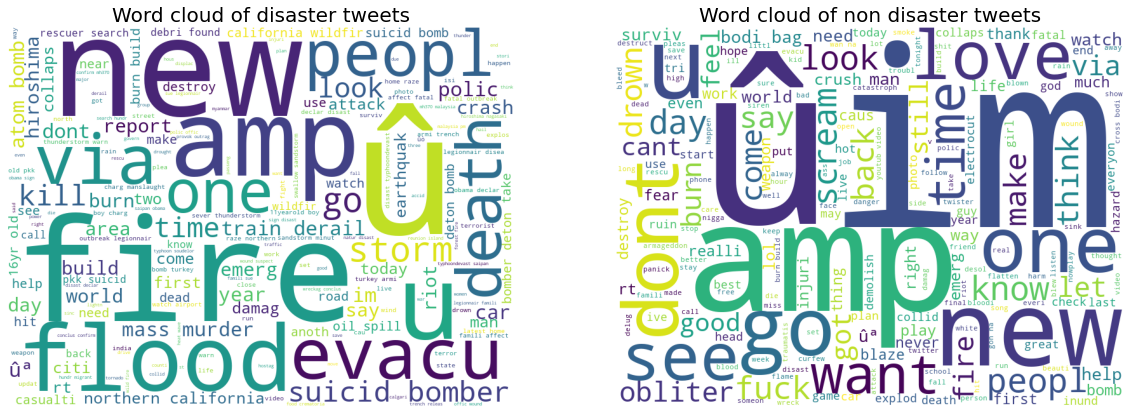

In [310]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 12))

wc_disaster = WordCloud(
        width=800, height=600,
        background_color='white',
        stopwords=STOPWORDS
    ).generate(' '.join(train[train.target==1]['text']))

wc_nondisaster = WordCloud(
        width=800, height=600,
        background_color='white',
        stopwords=STOPWORDS
    ).generate(' '.join(train[train.target==0]['text']))

ax1.imshow(wc_disaster)
ax1.set_title("Word cloud of disaster tweets", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_nondisaster)
ax2.set_title("Word cloud of non disaster tweets", fontsize=20)
ax2.axis("off")

fig.show()

## Text vectorization

To process the text data first we need to convert text data into numerical representation for systems to learn further from data. Vectorization is the process of converting a word ito a vector of numbers that contains the information in the word.

We will try:
* Bag-of-words vectorization
* TF-IDF vectorization

In [311]:
# Bag-of-words
count_vectorizer = CountVectorizer()
train_vectors_bow = count_vectorizer.fit_transform(train["text"])
test_vectors_bow = count_vectorizer.transform(test["text"])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
train_vectors_tf = tfidf_vectorizer.fit_transform(train["text"])
test_vectors_tf = tfidf_vectorizer.transform(test["text"])



## Training model

We will use logistic regression to train this model
.

In [312]:
# Bag-of-words
clf = LogisticRegression()

print("Bag-of-words:\n")
scores = cross_val_score(clf, train_vectors_bow, train["target"], cv=5, scoring="f1")
for k, score in zip(range(len(scores)),scores):
    print("F1 Score for fold %d is %.2f " % (k+1,score))
    
clf.fit(train_vectors_bow, train["target"])

# TF-IDF
clf = LogisticRegression()

print("\nTF-IDF:\n")
scores = cross_val_score(clf, train_vectors_tf, train["target"], cv=5, scoring="f1")
for k, score in zip(range(len(scores)),scores):
    print("F1 Score for fold %d is %.2f " % (k+1,score))
    
clf.fit(train_vectors_tf, train["target"])

Bag-of-words:

F1 Score for fold 1 is 0.76 
F1 Score for fold 2 is 0.73 
F1 Score for fold 3 is 0.73 
F1 Score for fold 4 is 0.74 
F1 Score for fold 5 is 0.75 

TF-IDF:

F1 Score for fold 1 is 0.73 
F1 Score for fold 2 is 0.70 
F1 Score for fold 3 is 0.70 
F1 Score for fold 4 is 0.72 
F1 Score for fold 5 is 0.73 


LogisticRegression()

### Making predictions using model


In [313]:
# Bag-of-words
test["pred"] = clf.predict(test_vectors_bow)

print("We got %.1f%% accuracy on our test dataset" % (float(accuracy_score(test.target, test.pred))*100))




We got 78.3% accuracy on our test dataset


In [314]:
# Bag-of-words
tn, fp, fn, tp = confusion_matrix(test.target, test.pred).ravel()
tot = confusion_matrix(test.target, test.pred).sum()

print("True Negative Rate: %.1f%%" % ((tn/tot)*100))
print("False Positive Rate: %.1f%%" % ((fp/tot)*100))
print("False Negative Rate: %.1f%%" % ((fn/tot)*100))
print("True Positive Rate: %.1f%%" % ((tp/tot)*100))



True Negative Rate: 44.9%
False Positive Rate: 11.9%
False Negative Rate: 9.8%
True Positive Rate: 33.5%


In [315]:
# TF-IDF
test["pred"] = clf.predict(test_vectors_tf)

print("We got %.1f%% accuracy on our test dataset" % (float(accuracy_score(test.target, test.pred))*100))


We got 80.4% accuracy on our test dataset


In [316]:
# TF_IDF
tn, fp, fn, tp = confusion_matrix(test.target, test.pred).ravel()
tot = confusion_matrix(test.target, test.pred).sum()

print("True Negative Rate: %.1f%%" % ((tn/tot)*100))
print("False Positive Rate: %.1f%%" % ((fp/tot)*100))
print("False Negative Rate: %.1f%%" % ((fn/tot)*100))
print("True Positive Rate: %.1f%%" % ((tp/tot)*100))



True Negative Rate: 51.2%
False Positive Rate: 5.6%
False Negative Rate: 14.1%
True Positive Rate: 29.2%


### Making predictions from competition test data

In [317]:
# Import data
comp_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# Check for missing data
comp_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [318]:
comp_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [319]:
# Isolating text column
test=comp_test[['text','id']]

In [320]:
## Cleaning and normalizing data

# Covert text to lowercase
test.text=test.text.apply(lambda text: lower_text(text))

# Remove newlines
test.text=test.text.apply(lambda text: remove_newline(text))

# Remove punctuations
test.text=test.text.apply(lambda text: remove_punctuations(text))

# Remove links
test.text=test.text.apply(lambda text: remove_links(text))

# Remove tags
test.text=test.text.apply(lambda text: remove_tags(text))

# Remove multiple spaces
test.text=test.text.apply(lambda text: remove_multiplespaces(text))

# Remove special characters
test.text=test.text.apply(lambda text: remove_specialchars(text))

# Remove stopwords
test.text=test.text.apply(lambda text: remove_stopwords(text))

# Apply Stemming
test.text=test.text.apply(lambda text: word_stemming(text))


In [328]:
## Predictions


test_vectors_tf = tfidf_vectorizer.transform(test["text"])

test["pred"] = clf.predict(test_vectors_tf)


## Exporting predictions

In [329]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

sample_submission["target"] = test["pred"]

sample_submission.to_csv("submission.csv", index=False)

sample_submission[:25]





,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [330]:
sample_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
